<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_irrigation_runoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Carli Beisel

Created: October 2024

Purpose: Find the amount of surface runoff from irrigation for each reach monthly. This data came from the Freshwater Trust.

In [1]:
#-------------------------------------------#
#     Import Packages & Connect to Drive    #
#-------------------------------------------#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --------------- #
#   Load Files    #
# --------------- #

# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_runoff = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/irrigation_runoff/irrigation_runoff.shp')

# reach delineation
reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final/Reaches_Final.shp')

In [ ]:
# --------------------------------------- #
# Create final dataframe for water budget
# --------------------------------------- #

#convert "annual" values in the column "month" to monthly by dividing by 12 and assigning each month the same value

data = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_irrigation_runoff.csv')
data = data.drop_duplicates()
flow_summary = data.groupby(['reach', 'month'], as_index=False)['flow'].sum()

output_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_monthly_runoff.csv'
flow_summary.to_csv(output_path, index=False)

Summarized flow data saved to /content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_monthly_runoff.csv


In [ ]:
# ------------------------ #
# Crop FWT data to Reaches
# ------------------------ #


output_csv_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_irrigation_runoff.csv'

if irrigation_runoff.crs != reaches.crs:
    reaches = reaches.to_crs(irrigation_runoff.crs)
irrigation_runoff_with_reach = gpd.sjoin(irrigation_runoff, reaches[['Reach', 'geometry']], how="inner", predicate="intersects")
irrigation_runoff_with_reach = irrigation_runoff_with_reach.rename(columns={'Reach': 'reach'})
irrigation_runoff_with_reach_df = irrigation_runoff_with_reach.drop(columns='geometry')

irrigation_runoff_with_reach_df.to_csv(output_csv_path, index=False)

print(f"Cropped and combined data exported to {output_csv_path}")


data = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_monthly_runoff.csv')
data = data.rename(columns={'reach': 'Reach'})
# Drop accidental identical rows
data = data.drop_duplicates()

# Separate annual and monthly data
annual_data = data[data['month'] == 'annual']
monthly_data = data[data['month'] != 'annual']

# List of all months
all_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Initialize a list to store updated rows
updated_rows = []

# Process each reach
for reach in annual_data['Reach'].unique():
    # Get the annual flow for this reach and compute the monthly portion
    annual_flow = annual_data.loc[annual_data['Reach'] == reach, 'flow'].iloc[0]
    monthly_portion = annual_flow / 12

    # Get the existing monthly data for this reach
    reach_monthly_data = monthly_data[monthly_data['Reach'] == reach]

    # Create a dictionary of existing months and their flows
    existing_months = reach_monthly_data.set_index('month')['flow'].to_dict()

    # Update or create monthly flows
    for month in all_months:
        if month in existing_months:
            # Add the monthly portion to existing flow
            updated_rows.append({
                'Reach': reach,
                'month': month,
                'flow': existing_months[month] + monthly_portion
            })
        else:
            # Create a new row for missing months
            updated_rows.append({
                'Reach': reach,
                'month': month,
                'flow': monthly_portion
            })

# Add data for reaches without annual flow
reaches_without_annual = set(monthly_data['Reach']) - set(annual_data['Reach'])
for reach in reaches_without_annual:
    reach_monthly_data = monthly_data[monthly_data['Reach'] == reach]
    updated_rows.extend(reach_monthly_data.to_dict('records'))

# Convert updated rows into a DataFrame
updated_data = pd.DataFrame(updated_rows)

# Group by 'Reach' and 'month' and sum the flows
final_data = updated_data.groupby(['Reach', 'month'], as_index=False)['flow'].sum()

final_datadata = final_data.rename(columns={'flow': 'flow(cfs)'})
final_data['flow(af)'] = final_data['flow(cfs)'] * 1.9835 * 86400 / 43560

# Save the final data to a CSV file
output_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_monthly_runoff_final.csv'
final_data.to_csv(output_path, index=False)

print(f"Summarized flow data saved to {output_path}")

# Display the first few rows of the final data
print(final_data.head())

Summarized flow data saved to /content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_monthly_runoff_final.csv
         Reach month         flow
0  Noble Drain   apr  1659.452374
1  Noble Drain   aug  2975.714453
2  Noble Drain   dec  1044.665089
3  Noble Drain   feb  1138.687529
4  Noble Drain   jan  1108.676362


<ipython-input-4-44445fe1cc8a>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-4-44445fe1cc8a>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-4-44445fe1cc8a>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-4-44445fe1cc8a>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-4-44445fe1cc8a>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-4-44445fe1cc8a>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


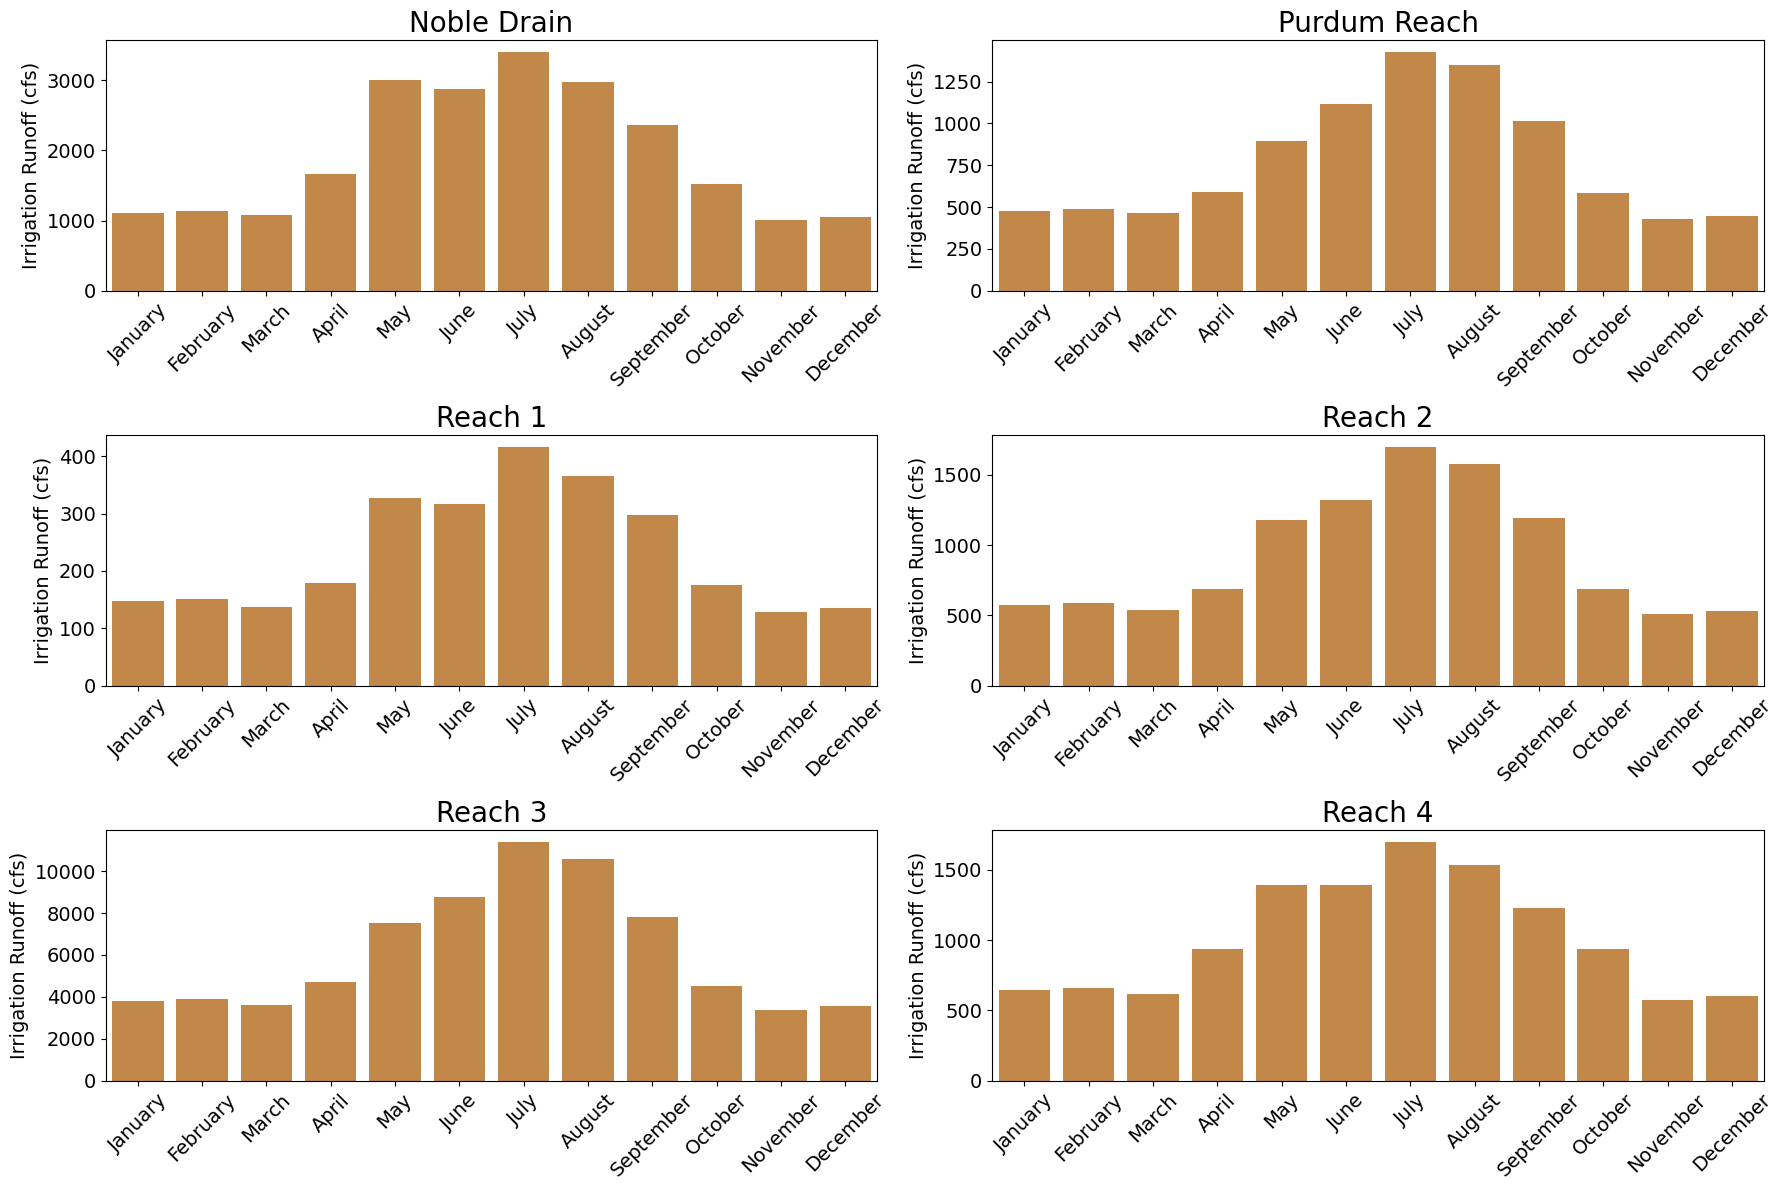

In [4]:
# ------------------------------ #
# Plot of Reach Irrigation Runoff
# ------------------------------ #

data = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_monthly_runoff_final.csv')

# Define the order of months with full names
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

data['month'] = pd.to_datetime(data['month'], format='%b').dt.strftime('%B') # full month names

reaches = data['Reach'].unique()

# Create a 3x2 panel (6 plots)
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

# Iterate over each reach and create a plot
for i, reach in enumerate(reaches):
    if i < len(axes):
        ax = axes[i]
        sns.barplot(
            data=data[data['Reach'] == reach],
            x='month', y='flow(cfs)', color='#D58936', ci=None, ax=ax,
            order=month_order  # x-axis is ordered by actual months
        )
        ax.set_title(reach, fontsize=20)
        ax.set_xlabel('')  # Remove x-axis label
        ax.set_ylabel('Irrigation Runoff (cfs)', fontsize=14)
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

# Remove unused axes
for j in range(len(reaches), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

output_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/mason_runoff_panel.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()